**Navdeep Singh Bedi**

In [1]:
!rm -r AI2022MA/
!git clone https://github.com/UmbertoJr/AI2022MA.git

Cloning into 'AI2022MA'...
remote: Enumerating objects: 356, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 356 (delta 31), reused 73 (delta 16), pack-reused 265
Receiving objects: 100% (356/356), 13.21 MiB | 23.33 MiB/s, done.
Resolving deltas: 100% (161/161), done.


# The Orienteering Problem with Time Windows

column of X:

0. index of the customer
1. x coordinate
2. y coordinate
3. lower time window
4. upper time window
5. reward customer
6. global time constraint

adj is the distance matrix

In [2]:
import numpy as np
from AI2022MA.OPTW import Env, plot_instance

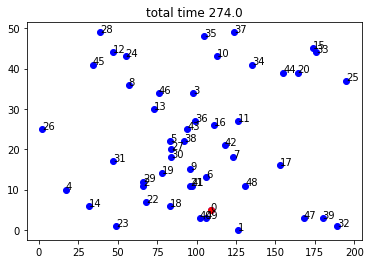

[[0.00e+00 1.09e+02 5.00e+00 0.00e+00 2.74e+02 0.00e+00 2.74e+02]
 [1.00e+00 1.26e+02 0.00e+00 2.13e+02 2.32e+02 1.70e-01 2.74e+02]
 [2.00e+00 6.60e+01 1.10e+01 2.31e+02 2.31e+02 4.00e-01 2.74e+02]
 [3.00e+00 9.80e+01 3.40e+01 1.31e+02 1.69e+02 2.90e-01 2.74e+02]
 [4.00e+00 1.70e+01 1.00e+01 1.82e+02 1.82e+02 8.40e-01 2.74e+02]]
(50, 7)
(50, 50)


In [3]:
env = Env(from_file=True, instance_number=0)
X = np.array(env.x)
adj = env.adj
plot_instance(X)
print(X[:5])
print(X.shape)
print(adj.shape)

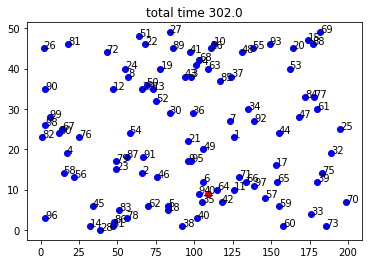

[[0.00e+00 1.09e+02 9.00e+00 0.00e+00 3.02e+02 0.00e+00 3.02e+02]
 [1.00e+00 1.26e+02 2.30e+01 2.06e+02 2.25e+02 2.00e-01 3.02e+02]
 [2.00e+00 6.60e+01 1.40e+01 4.00e+01 7.10e+01 3.80e-01 3.02e+02]
 [3.00e+00 9.80e+01 3.80e+01 1.17e+02 1.49e+02 2.80e-01 3.02e+02]
 [4.00e+00 1.70e+01 1.90e+01 2.09e+02 2.09e+02 8.20e-01 3.02e+02]]
(100, 7)
(100, 100)


In [4]:
env = Env(from_file=True, instance_number=1)
X = np.array(env.x)
adj = env.adj
plot_instance(X)
print(X[:5])
print(X.shape)
print(adj.shape)

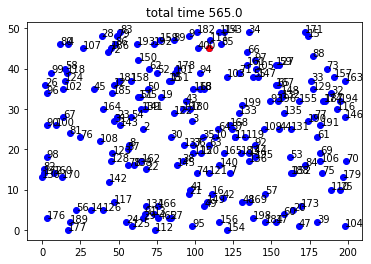

[[0.00e+00 1.09e+02 4.50e+01 0.00e+00 5.65e+02 0.00e+00 5.65e+02]
 [1.00e+00 1.26e+02 2.30e+01 1.41e+02 1.78e+02 2.50e-01 5.65e+02]
 [2.00e+00 6.60e+01 2.50e+01 5.18e+02 5.18e+02 4.10e-01 5.65e+02]
 [3.00e+00 9.80e+01 2.70e+01 2.40e+01 7.10e+01 1.90e-01 5.65e+02]
 [4.00e+00 1.70e+01 4.60e+01 4.73e+02 4.73e+02 8.00e-01 5.65e+02]]
(200, 7)
(200, 200)


In [5]:
env = Env(from_file=True, instance_number=2)
X = np.array(env.x)
adj = env.adj
plot_instance(X)
print(X[:5])
print(X.shape)
print(adj.shape)

time window violated 225.0 
current time  233.0 
from node 1  to  49
(233.0, 0, False)


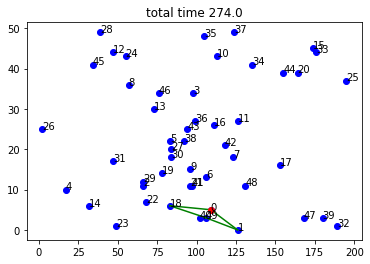

In [6]:
sol = [0, 1, 49, 18, 0]
env = Env(from_file=True, instance_number=0, verbose=True)
print(env.check_solution(sol))
plot_instance(env.x, sol)

(236.0, 0.44999999999999996, True)


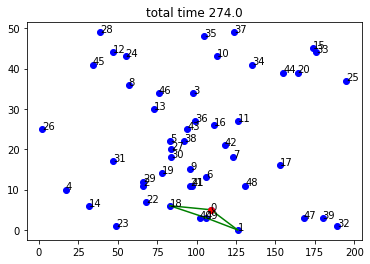

In [7]:
sol = [0, 18, 49, 1, 0]
env = Env(from_file=True, instance_number=0, verbose=True)
print(env.check_solution(sol))
plot_instance(env.x, sol)

In [8]:
### Node Object ###
class Node:
    def __init__(self, parent, node, travel_time, partial_path, current_reward, expandable_customers):
      self.parent = parent                                                      # parent node object 
      self.node = node                                                          # current node (or customer) index
      self.partial_path = partial_path                                          # current partial path across customers
      self.current_reward = current_reward                                      # current reward collected in the partial path
      self.num_of_visit = 0                                                     # number of visit to the current node during the MCTS 
      self.terminal = False                                                     # boolean to determine if node is terminal
      self.fully_expanded = False                                               # boolean to determine if node was expanded completely during the search
      self.estimated_reward = 0                                                 # esteem of the future reward collected thanks to the MC simulations
      self.travel_time = travel_time                                            # travel time spent with the current partial path
      self.score = None                                                         # Upper Confidence Buond score for node
      self.policy = None                                                        # IMPORTANT !!!!! Best node index according to the UCB score 
      self.expandables = copy.deepcopy(expandable_customers)                    # customers in the candidate list of the current node that are not in the current path
      self.expanded = {}                                                        # nodes already expanded during the search
      if len(self.expandables) == 0:                                            
        self.fully_expanded = True
        self.terminal = True
        self.partial_path.append(0)
        self.policy = 0

    def calculateUCTscore(self, best_reward_so_far):
      # computes the Upper Confidence Bound for the Node
      c=1/(2**0.5)
      self.score = (((self.estimated_reward/ self.num_of_visit) + self.current_reward) /
                    best_reward_so_far) + c * 2 * (2 * np.log(self.parent.num_of_visit) / 
                                                   self.num_of_visit) ** 0.5


In [9]:
from time import time
import copy
import numpy as np
from scipy.special import softmax
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')


Here, first I implement the "treePolicy" function for the node which is not the terminal node and if that node is not fully expanded then I expand the node and if the node cannot be further expanded (i.e. the terminal node is reached) then I return the best child.

Next, I implement the select "selectBestChild" function in which I select each child node of the selected node and calculate the UCT score with maximum reward. Then if child's score is better than the best score then I assign the child's score to the best score and that child as the best child and return the best child.

Then, I implement the "backup" function in which I backpropogate the result from the child to the parent by increasing the number of visit and the estimated reward.

I also apply the variant by changing the candidate list for the root node in which instead of using just the lower time window (the earliest available time for the node) for the probability to include the node in the path I also used the upper time window (the latest available time for the node).

In [10]:
class MCTS:
  def __init__(self, env,time_limit, initial_path, variant):
    self.num_of_customers = env.n_nodes                                         # number of customers in the current problem
    self.env = env                                                              # environment of the problem to solve
    self.time_limit = time_limit                                                # time budget for the OPTW to solve
    self.initial_path = initial_path                                            # initial path
    self.root_node = initial_path[-1] 
    self.variant = variant                                          # root node index

    # saving the best tour so far, its reward and time travel
    self.best_tour_so_far = initial_path + [0]
    travel_time, self.max_reward, _ = self.env.check_solution(self.best_tour_so_far)

    # these operations find the promising CL for the root node
    ordered_view = {i: self.env.x[i, 5]/(self.env.x[i, 3] / self.env.x[i, 6]) for i in range(1, self.num_of_customers) if i not in initial_path 
                    and self.env.adj[self.root_node, i] + travel_time < self.env.x[i, 4]
                    and self.env.adj[i, 0] + self.env.adj[self.root_node, i] + travel_time < self.env.x[i, 6]}
    ordered_list = [k for k, v in sorted(ordered_view.items(), key=lambda item: item[1]) if k not in initial_path]

    # initialize the root node
    self.root = Node(parent=None,
                     node= self.root_node,
                     travel_time =travel_time,
                     partial_path=initial_path,
                     current_reward=0, 
                     expandable_customers = ordered_list)
    

  def treePolicy(self, node):
    """
    This function expand a node if the selected node is not being completely expanded,
    otherwise it select the best child in the Tree using the selectBestChild function
    """
    while not node.terminal:
      if not node.fully_expanded:
        return self.expand(node)
      else:
        node = self.selectBestChild(node)
    return node


  def selectBestChild(self, node):
    """
    The function updates the UBC score for each child node by employing the updated max_reward
    then it returns the best child according to such score. 
    """
    best_score = 0
    best_child = None
    
    for child_idx in node.expanded.keys():
      node.expanded[child_idx].calculateUCTscore(self.max_reward)
    
      if node.expanded[child_idx].score > best_score:
        best_score = node.expanded[child_idx].score
        best_child = node.expanded[child_idx]
        node.policy = child_idx

    return best_child


  def expand(self, node):
    new_node = node.expandables.pop()                                           # it selects the most promising node from the CL 
    new_path = copy.deepcopy(node.partial_path)                                 # it copies the path and append new node to it
    new_path.append(new_node)
        
    new_reward = node.current_reward                                            # update of the reward for the new customer
    new_reward += self.env.x[new_node, 5]

    new_travel_time = max(node.travel_time + self.env.adj[node.node, new_node], # updated the travel time
                          self.env.x[new_node, 3])

    # these operations find the promising CL for the root node
    ordered_view = {i: self.env.x[i, 5]/(self.env.x[i, 3] / self.env.x[i, 6]) for i in range(1, self.num_of_customers) if i not in new_path 
                    and self.env.adj[new_node, i] + new_travel_time < self.env.x[i, 4]
                    and self.env.adj[i, 0] + self.env.adj[new_node, i] + new_travel_time < self.env.x[i, 6]}
    ordered_list = [k for k, v in sorted(ordered_view.items(), key=lambda item: item[1]) if k not in new_path]

    new_node_object = Node(parent=node,
                           node=new_node,
                           travel_time=new_travel_time,
                           partial_path=new_path,
                           current_reward=new_reward, 
                           expandable_customers=ordered_list)
    
    node.expanded[new_node] = new_node_object
    if len(node.expandables) == 0:
      node.fully_expanded = True
      
    if new_node == 0:
      new_node_object.terminal = True
      _, new_r, _ = self.env.check_solution(new_path)
      if new_r > self.max_reward:
        self.max_reward = new_r
        self.best_tour_so_far = new_path

    return new_node_object

  def defaultPolicy(self, starting_node):
    # reach the end, break condition
    if starting_node.node == 0:
      return 0

    customer = starting_node.node
    new_path = starting_node.partial_path
    travel_time = starting_node.travel_time
    while customer != 0:
      if self.variant == 'original':
        # these operations find the promising CL for the root node
        ordered_view = {i: (self.env.x[i, 5] + np.finfo(float).eps)/(self.env.x[i, 3] / self.env.x[i, 6] + np.finfo(float).eps ) for i in range(1, self.num_of_customers) if i not in new_path 
                        and self.env.adj[customer, i] + travel_time < self.env.x[i, 4] 
                        and self.env.adj[i, 0] + self.env.adj[customer, i] + travel_time < self.env.x[i, 6]}
      else:
        ordered_view = {i: (self.env.x[i, 5] + np.finfo(float).eps)/((self.env.x[i, 3] / self.env.x[i, 6] + np.finfo(float).eps )*(self.env.x[i, 4] / self.env.x[i, 6] + np.finfo(float).eps )) for i in range(1, self.num_of_customers) if i not in new_path 
                        and self.env.adj[customer, i] + travel_time < self.env.x[i, 4] 
                        and self.env.adj[i, 0] + self.env.adj[customer, i] + travel_time < self.env.x[i, 6]}
      ordered_list = [k for k, v in sorted(ordered_view.items(), key=lambda item: -item[1]) if k not in new_path]
      if len(ordered_list) == 0:
        customer = 0
      else:
        probabilities = softmax(np.array([v for k, v in sorted(ordered_view.items(), key=lambda item: -item[1]) if k not in new_path]))
        customer = int(np.random.choice(ordered_list, 1, p=probabilities))
      
      new_path.append(customer)
      travel_time = max(travel_time + self.env.adj[new_path[-2], customer], self.env.x[customer, 3])
      
    _, new_r, _ = self.env.check_solution(new_path) 
    if new_r > self.max_reward:
        self.max_reward = new_r
        self.best_tour_so_far = new_path

    return new_r - starting_node.current_reward
      

  def backup(self, node, reward_esteem):
    """
    backup of the estimated reward in the MCTS
    """
    while node.parent is not None:
      node.num_of_visit += 1
      node.estimated_reward += reward_esteem
      node = node.parent
    # pass

  def step(self, num_of_simulation=1):
    start = time()
    while time() - start < self.time_limit:
        current_node = self.treePolicy(self.root)
        reward_esteem = self.defaultPolicy(current_node)
        self.backup(current_node, reward_esteem)

    return self.root.policy if self.root.policy != None else 0

In [11]:
data_frame = []

I run the algorithm for 3 different instances, 3 different seeds and 2 variants and plot the results.

========== Variant: original ==========
========== Instance: 0 ==========
========== Seed: 0 ==========
(274.0, 1.6600000000000001, True)


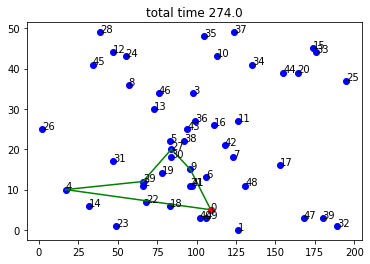

(274.0, 2.6500000000000004, True)


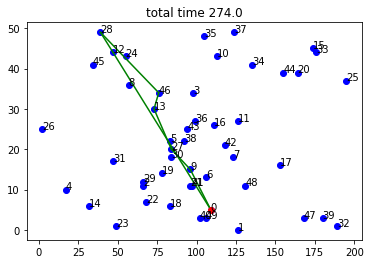

========== Seed: 42 ==========
(274.0, 1.6600000000000001, True)


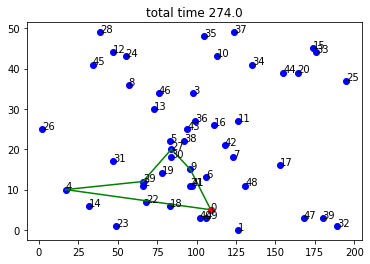

(274.0, 2.25, True)


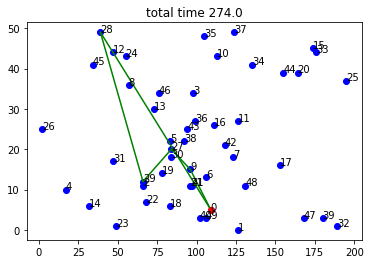

========== Seed: 123 ==========
(274.0, 1.6600000000000001, True)


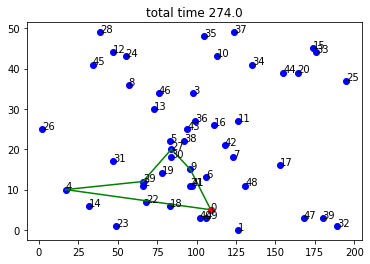

(274.0, 2.25, True)


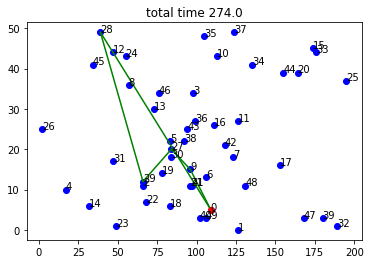

========== Instance: 1 ==========
========== Seed: 0 ==========
(302.0, 1.55, True)


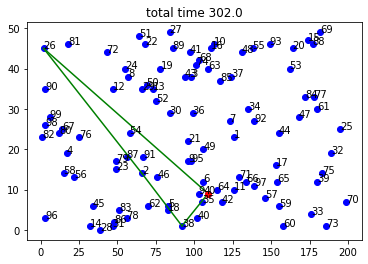

(302.0, 1.9000000000000001, True)


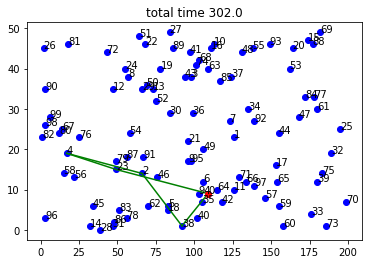

========== Seed: 42 ==========
(302.0, 1.55, True)


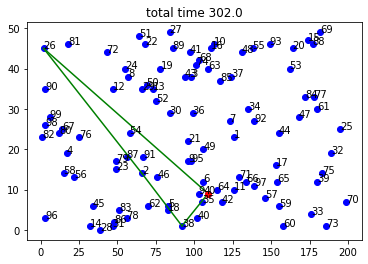

(302.0, 1.9000000000000001, True)


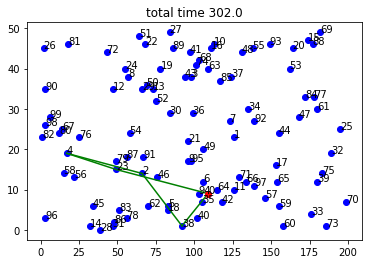

========== Seed: 123 ==========
(302.0, 1.55, True)


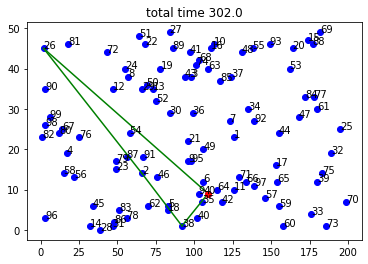

(302.0, 1.9000000000000001, True)


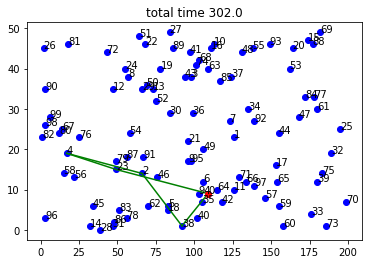

========== Instance: 2 ==========
========== Seed: 0 ==========
(565.0, 3.78, True)


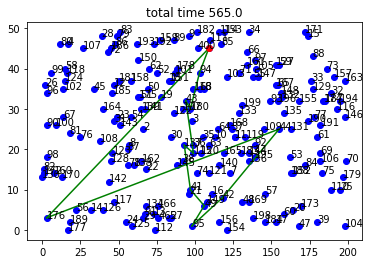

(565.0, 4.76, True)


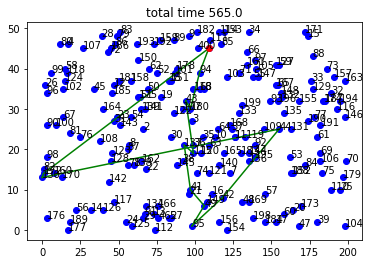

========== Seed: 42 ==========
(565.0, 3.78, True)


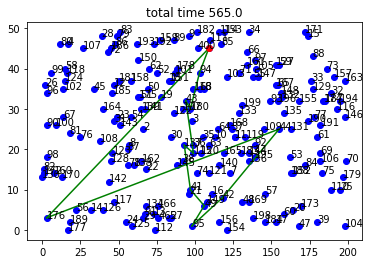

(565.0, 4.8500000000000005, True)


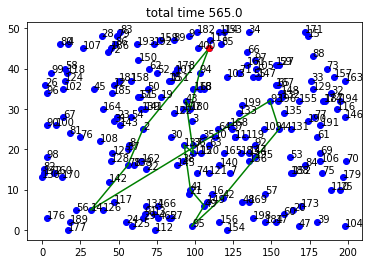

========== Seed: 123 ==========
(565.0, 3.78, True)


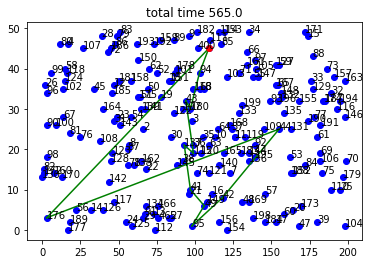

(565.0, 4.78, True)


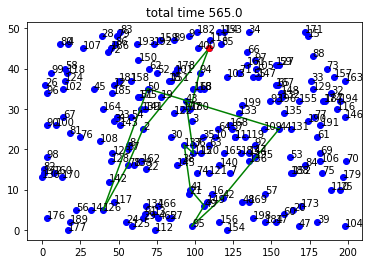

========== Variant: new ==========
========== Instance: 0 ==========
========== Seed: 0 ==========
(274.0, 1.6600000000000001, True)


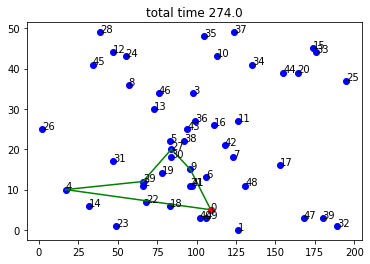

(274.0, 2.7800000000000002, True)


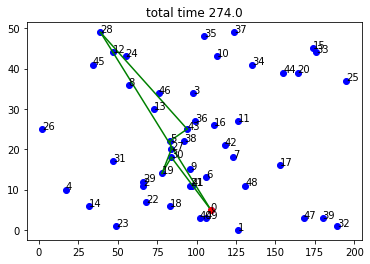

========== Seed: 42 ==========
(274.0, 1.6600000000000001, True)


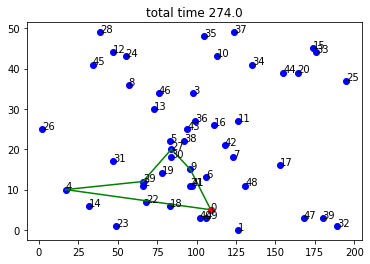

(274.0, 3.04, True)


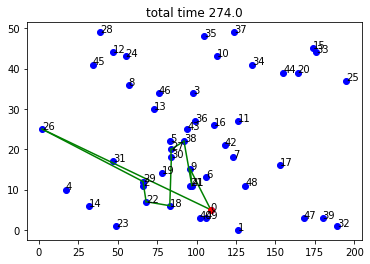

========== Seed: 123 ==========
(274.0, 1.6600000000000001, True)


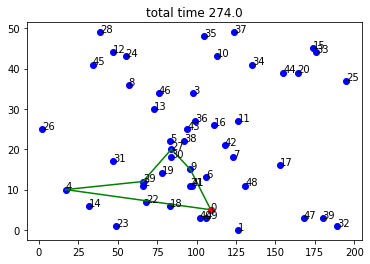

(274.0, 2.87, True)


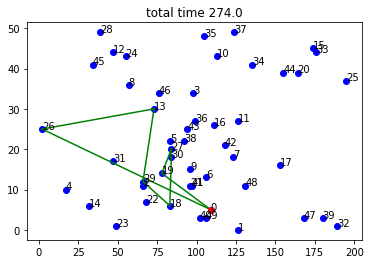

========== Instance: 1 ==========
========== Seed: 0 ==========
(302.0, 1.55, True)


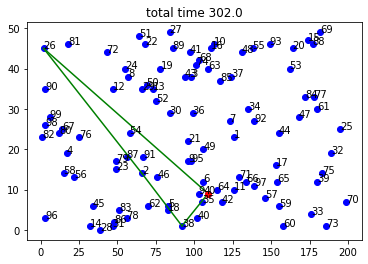

(302.0, 2.3, True)


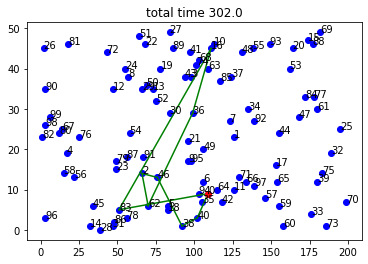

========== Seed: 42 ==========
(302.0, 1.55, True)


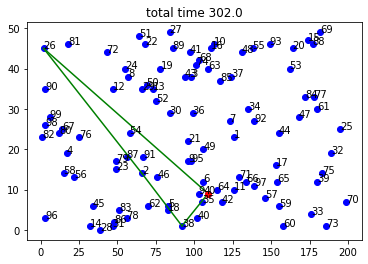

(302.0, 2.12, True)


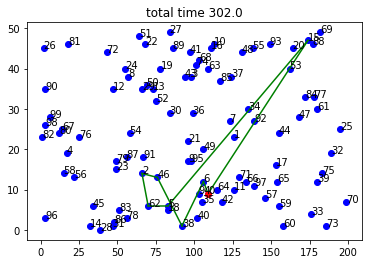

========== Seed: 123 ==========
(302.0, 1.55, True)


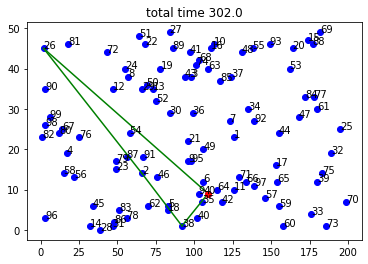

(302.0, 2.19, True)


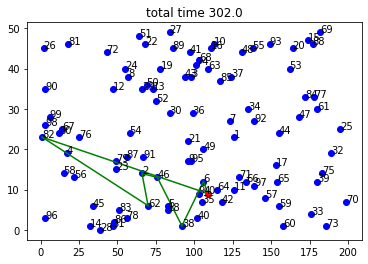

========== Instance: 2 ==========
========== Seed: 0 ==========
(565.0, 3.78, True)


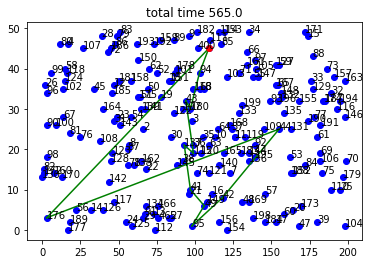

(565.0, 6.530000000000001, True)


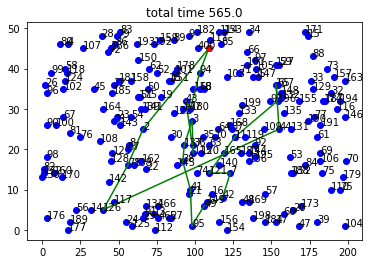

========== Seed: 42 ==========
(565.0, 3.78, True)


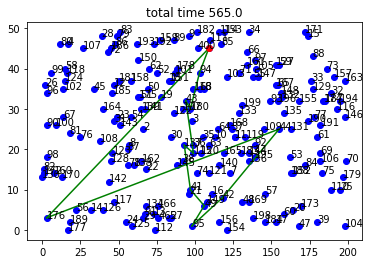

(565.0, 5.319999999999999, True)


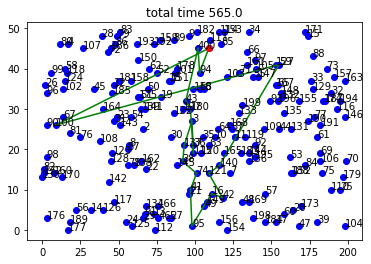

========== Seed: 123 ==========
(565.0, 3.78, True)


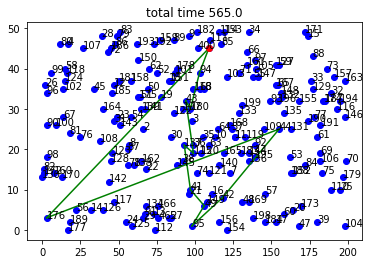

(565.0, 5.58, True)


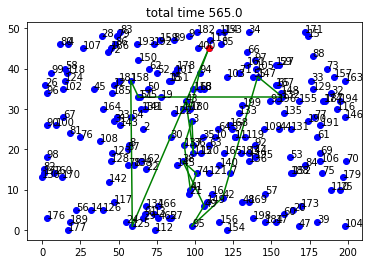

In [12]:
instances = [0, 1, 2]
seeds = [0, 42, 123]
variants = ['original', 'new']
for variant in variants:
  print(f'========== Variant: {variant} ==========')
  for instance in instances:
    print(f'========== Instance: {instance} ==========')
    for seed in seeds:
      print(f'========== Seed: {seed} ==========')
      np.random.seed(seed)
      env = Env(from_file=True, instance_number=instance)
      time_limit = 5
      sol = [0]
      best_sol = None
      best_r = 0
      while True:
        mcts = MCTS(env, time_limit, sol, variant)
        mcts.best_tour_so_far = best_sol
        mcts.max_reward = best_r
        new_customer = mcts.step()
        sol.append(new_customer)
        if mcts.max_reward > best_r:
          best_r = mcts.max_reward
          best_sol = mcts.best_tour_so_far
        if sol[-1] == 0:
          break
      frame = []
      frame.append(variant)
      frame.append(instance)
      frame.append(seed)
      frame.append(env.check_solution(best_sol)[0])
      frame.append(env.check_solution(sol)[1])
      frame.append(env.check_solution(best_sol)[1])
      data_frame.append(frame)
      print(env.check_solution(sol))
      plot_instance(env.x, sol)
      print(env.check_solution(best_sol))
      plot_instance(env.x, best_sol)

In [13]:
import pandas as pd

The results are listed below. We can see that including upper time window in addition to the lower time window for the probabilty to include the node in the path significantly improves the results as lower the latest time more the probability of the node to be included in the path.

In [14]:
c_labels = ['variant', 'instance', 'seed', 'total_time_sol', 'reward_sol', 'reward_best_sol']
df = pd.DataFrame(data_frame, columns=c_labels)
df

,variant,instance,seed,total_time_sol,reward_sol,reward_best_sol
0,original,0,0,274.0,1.66,2.65
1,original,0,42,274.0,1.66,2.25
2,original,0,123,274.0,1.66,2.25
3,original,1,0,302.0,1.55,1.90
4,original,1,42,302.0,1.55,1.90
5,original,1,123,302.0,1.55,1.90
6,original,2,0,565.0,3.78,4.76
7,original,2,42,565.0,3.78,4.85
8,original,2,123,565.0,3.78,4.78
9,new,0,0,274.0,1.66,2.78
